In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Data Review

In [3]:
train_df = pd.read_csv('titanic_train_raw.csv')
test_df = pd.read_csv('titanic_test_raw.csv')

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Handling Missing Data

### Removing features

In [6]:
def drop_columns(input_df, threshold, unique_value_threshold):
    df = input_df
    to_be_dropped = []
    for column in df:
        missing = df[column].isnull().sum() / len(df) * 100
        unique_missing = df[column].nunique() / len(df) * 100
        if missing > threshold:
            to_be_dropped.append(column)
        if unique_missing < unique_value_threshold:
            to_be_dropped.append(column)
    df = df.drop(to_be_dropped, axis=1)
    return df

In [7]:
drop_columns(train_df, 80, 15).columns

Index(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], dtype='object')

### Data imputation    

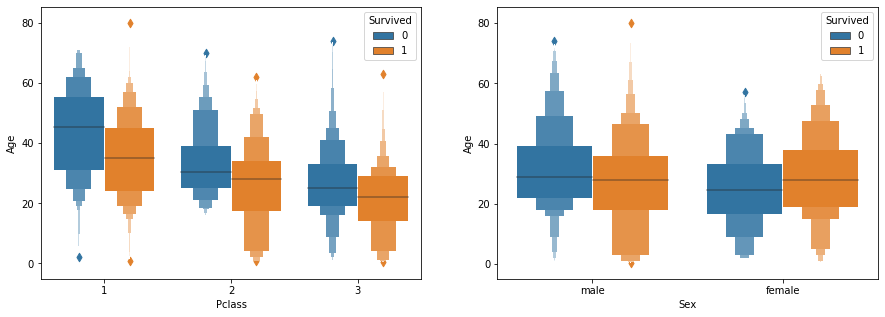

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.boxenplot(train_df['Pclass'], train_df['Age'], hue=train_df['Survived'])
plt.subplot(1, 2, 2)
sns.boxenplot(train_df['Sex'], train_df['Age'], hue=train_df['Survived'])
plt.show()

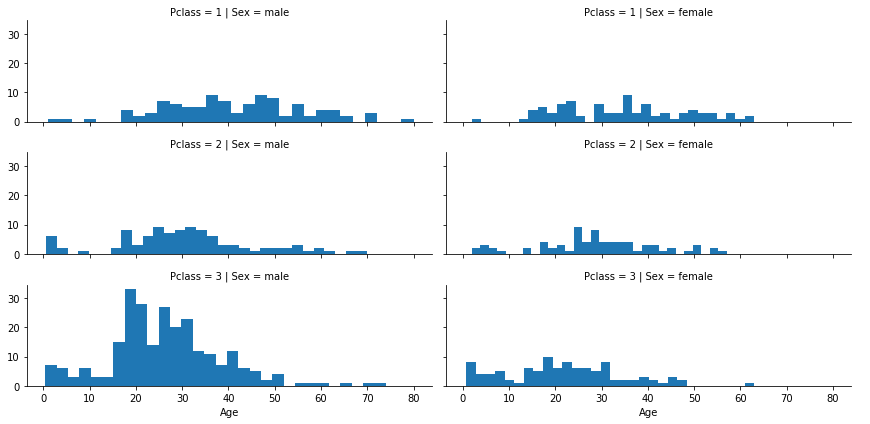

In [9]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.0, aspect=3.0)
grid.map(plt.hist, 'Age', bins=30)
grid.add_legend()
plt.show()

In [10]:
def conditional_impute(input_df, choice='median'):
    df = input_df
    if choice not in ['median', 'mean']:
        raise ValueError
    
    sex_class = df.groupby(['Sex', 'Pclass'])
    
    def impute_median(series):
        return series.fillna(series.median())
    def impute_mean(series):
        return series.fillna(series.mean())

    if choice == 'median':
        df.Age = sex_class['Age'].transform(impute_median)
    elif choice == 'mean':
        df.Age = sex_class['Age'].transform(impute_mean)
    return df

In [11]:
conditional_impute(train_df, choice='median')[['Name','Age']].tail()

,Name,Age
886,"Montvila, Rev. Juozas",27.0
887,"Graham, Miss. Margaret Edith",19.0
888,"Johnston, Miss. Catherine Helen ""Carrie""",21.5
889,"Behr, Mr. Karl Howell",26.0
890,"Dooley, Mr. Patrick",32.0


## Feature Engineering

### Extract titles

In [12]:
def extract_title(input_df):
    df = input_df
    for title in df:
        df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False) + '.'
    return df

In [13]:
extract_title(train_df).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


### Feature selection

In [14]:
title_df = pd.read_csv('titanic_train_title.csv')
pd.crosstab(index=title_df['Title'], columns=title_df['Sex'])

Sex,female,male
Title,,
Capt.,0,1
Col.,0,2
Countess.,1,0
Don.,0,1
Dr.,1,6
Jonkheer.,0,1
Lady.,1,0
Major.,0,2
Master.,0,40


In [15]:
def group_titles(input_df, uncommon_titles):
    df = input_df
    df['Title'] = df['Title'].replace(uncommon_titles, 'Uncommon')
    return df

In [16]:
uncommon_titles = ['Don.', 'Rev.', 'Mme.','Major.', 'Sir.', 'Mlle.','Countess.', 'Jonkheer.']
group_titles(title_df, uncommon_titles)['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Uncommon', 'Dr.', 'Ms.',
       'Lady.', 'Col.', 'Capt.'], dtype=object)

### Feature encoding

In [17]:
title_regrouped_df = pd.read_csv('titanic_train_title_regrouped.csv')

In [18]:
def dummy_encode_titles(input_df):
    df = input_df
    return pd.get_dummies(df, columns = ['Title'], prefix = 'Title', drop_first = True)

In [19]:
encode_df = dummy_encode_titles(title_regrouped_df)
dummy_cols = [col for col in encode_df if col.startswith('Title')]
encode_df[dummy_cols].head()

,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Uncommon
0,0,1,0,0
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,1,0,0
